# gpOptimizer: Mini Application

In [1]:
## First, install the right version of gpCAM
# pip install gpcam==8.2.0

## Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from gpcam import GPOptimizer
import time

In [3]:
from itertools import product
x_pred1D = np.linspace(0,1,1000).reshape(-1,1)

## Data Prep

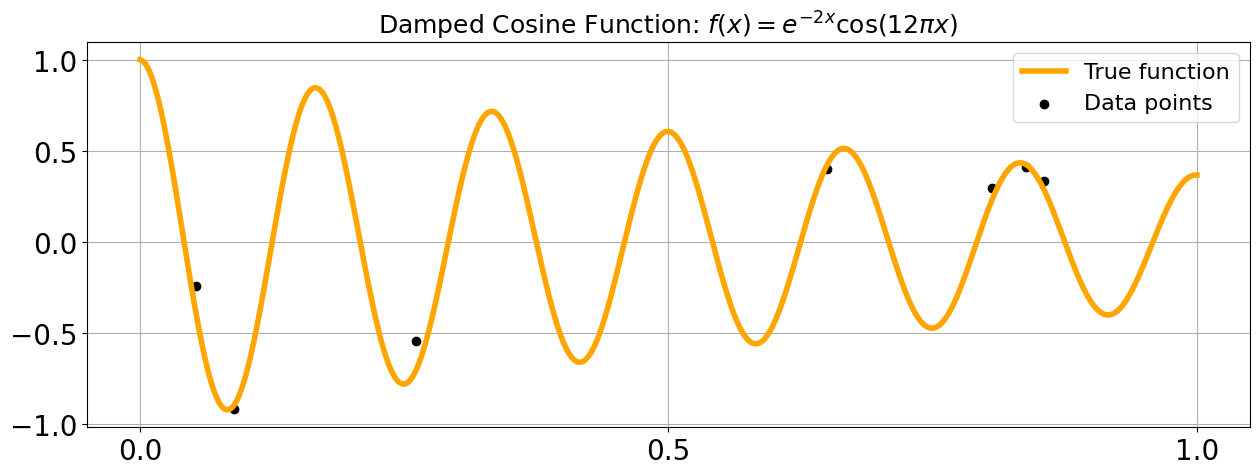

In [4]:

x = np.linspace(0, 1, 1000)

noise_level = 0.1

var = (noise_level  / np.sqrt(3))  # Variance of the noise, assuming uniform distribution in [-noise_level, noise_level]

def f1(x, decay=1.0, freq=12.0, noise_std=noise_level, noise_enabled=True, seed=None):
    """ 
    Funktion: exp(-decay * x) * cos(2 * pi * freq * x) + Rauschen

    Parameter:
    - x: Eingabewerte (1D numpy array)
    - decay: Abklingrate des Exponentialterms
    - freq: Frequenz des Cosinus (in Vielfachen von pi)
    - noise_std: Standardabweichung des Gaußschen Rauschens
    - noise_enabled: ob Rauschen hinzugefügt wird (bool)
    - seed: Zufallssamen für reproduzierbare Rauschwerte (int oder None)
    """
    if seed is not None:
        np.random.seed(seed)
    signal = np.exp(-decay * x) * np.cos(freq * np.pi * x)
    if noise_enabled:
        noise = np.random.normal(0, noise_std, size=len(x))
        return signal + noise
    else:
        return signal
# Beispielnutzung

def f1_without_noise(x, decay=1.0, freq=12.0):

    return np.exp(-decay * x) * np.cos(freq * np.pi * x)


x_data = np.random.rand(7).reshape(-1, 1)
y_data = f1(x_data[:, 0],  freq=12.0, noise_enabled=True, seed=42)

plt.figure(figsize=(15, 5))
plt.xticks([0., 0.5, 1.0], fontsize=20)
plt.yticks([-1.0, -0.5, 0., 0.5, 1.0], fontsize=20)
plt.plot(x, f1_without_noise(x), color='orange', linewidth=4, label="True function")
plt.scatter(x_data[:, 0], y_data, color='black', label="Data points")
plt.legend(fontsize=16)
plt.title("Damped Cosine Function: $f(x) = e^{-2x} \\cos(12\\pi x)$", fontsize=18)
plt.grid(True)
plt.show()

## GP Setup

c:\Users\Leo\Desktop\GP bootcamp\.venv\Lib\site-packages\fvgp\gp.py:248: UserWarning: Hyperparameters initialized to a vector of ones.
  warnings.warn("Hyperparameters initialized to a vector of ones.")
c:\Users\Leo\Desktop\GP bootcamp\.venv\Lib\site-packages\fvgp\gp.py:292: UserWarning: No noise function or measurement noise provided. Noise variances will be set to (0.01 * mean(|y_data|))^2.
  self.likelihood = GPlikelihood(self.data,
c:\Users\Leo\Desktop\GP bootcamp\.venv\Lib\site-packages\fvgp\gp.py:523: UserWarning: Default hyperparameter_bounds initialized because none were provided. This will fail for custom kernel, mean, or noise functions
  warnings.warn("Default hyperparameter_bounds initialized because none were provided. "


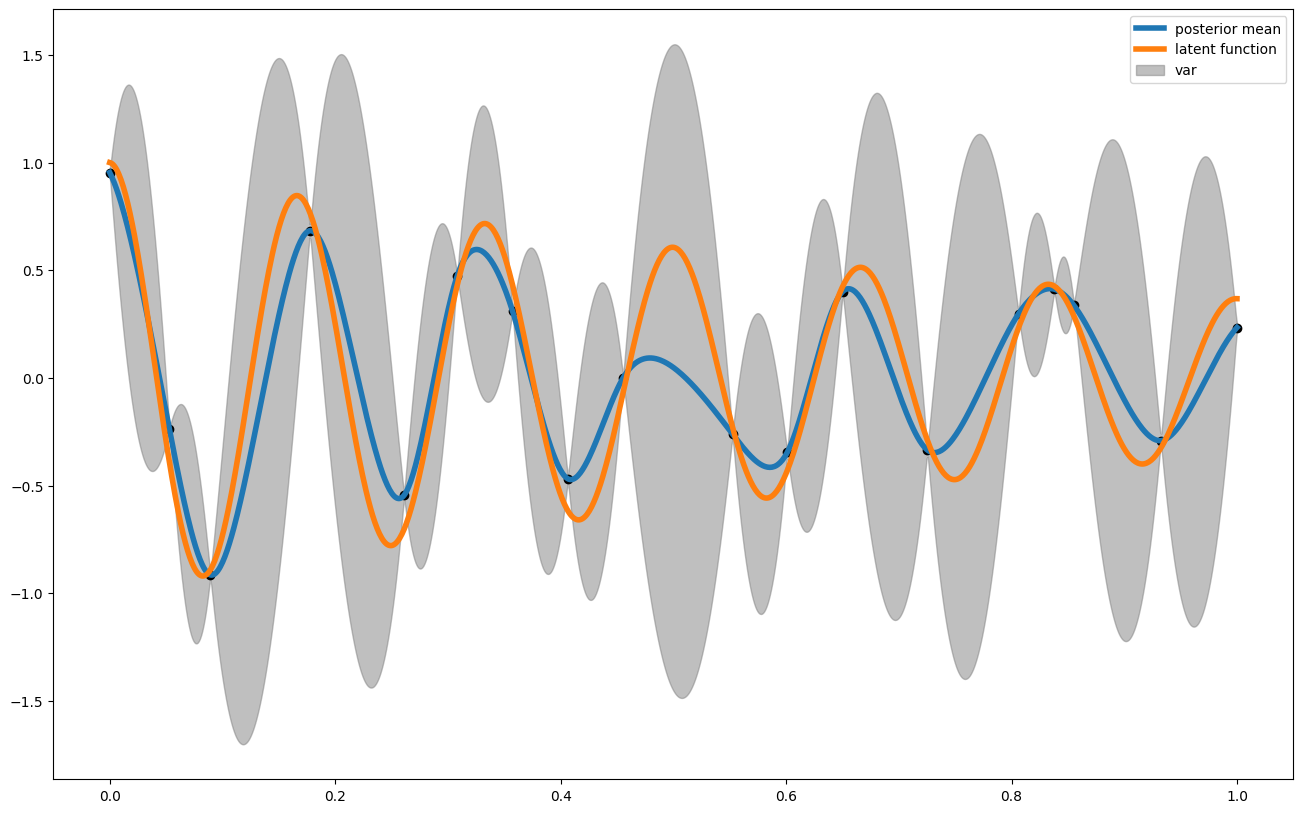

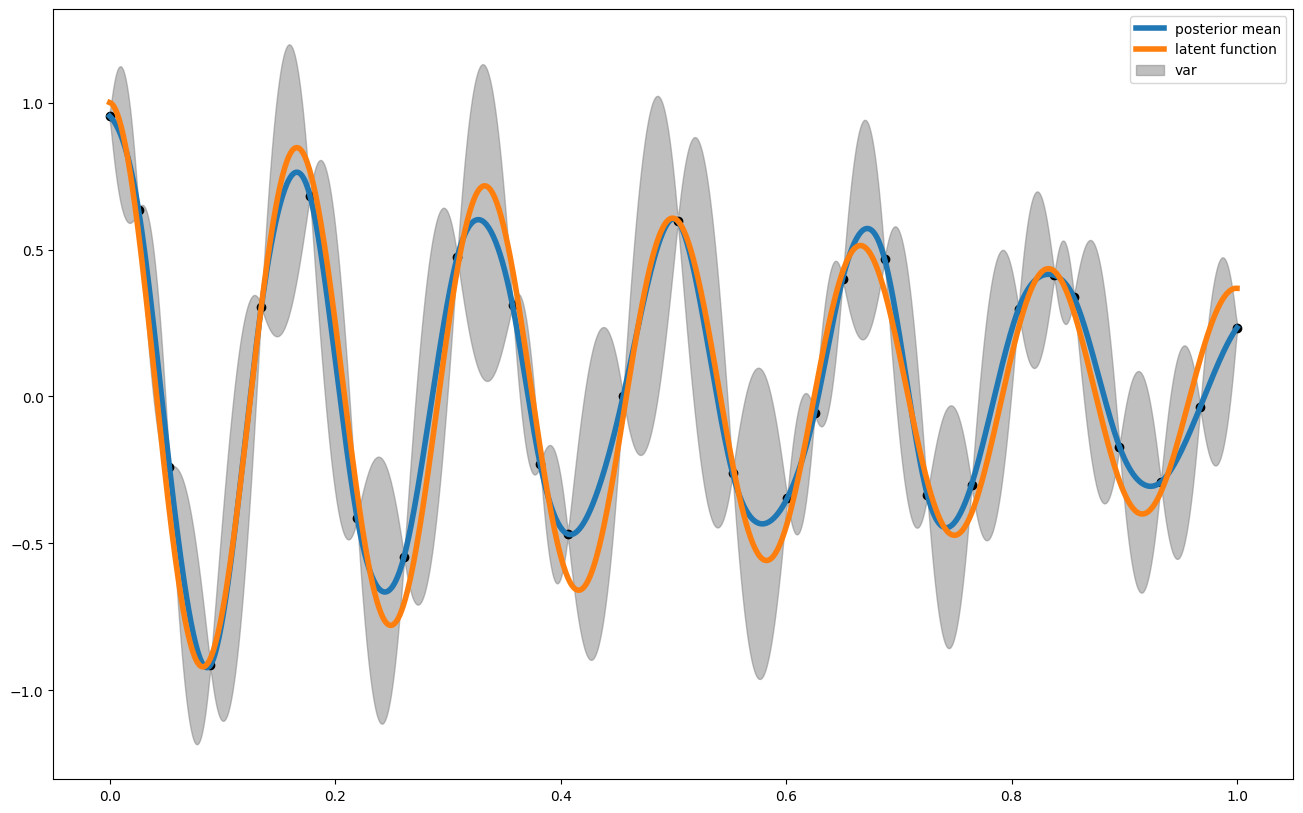

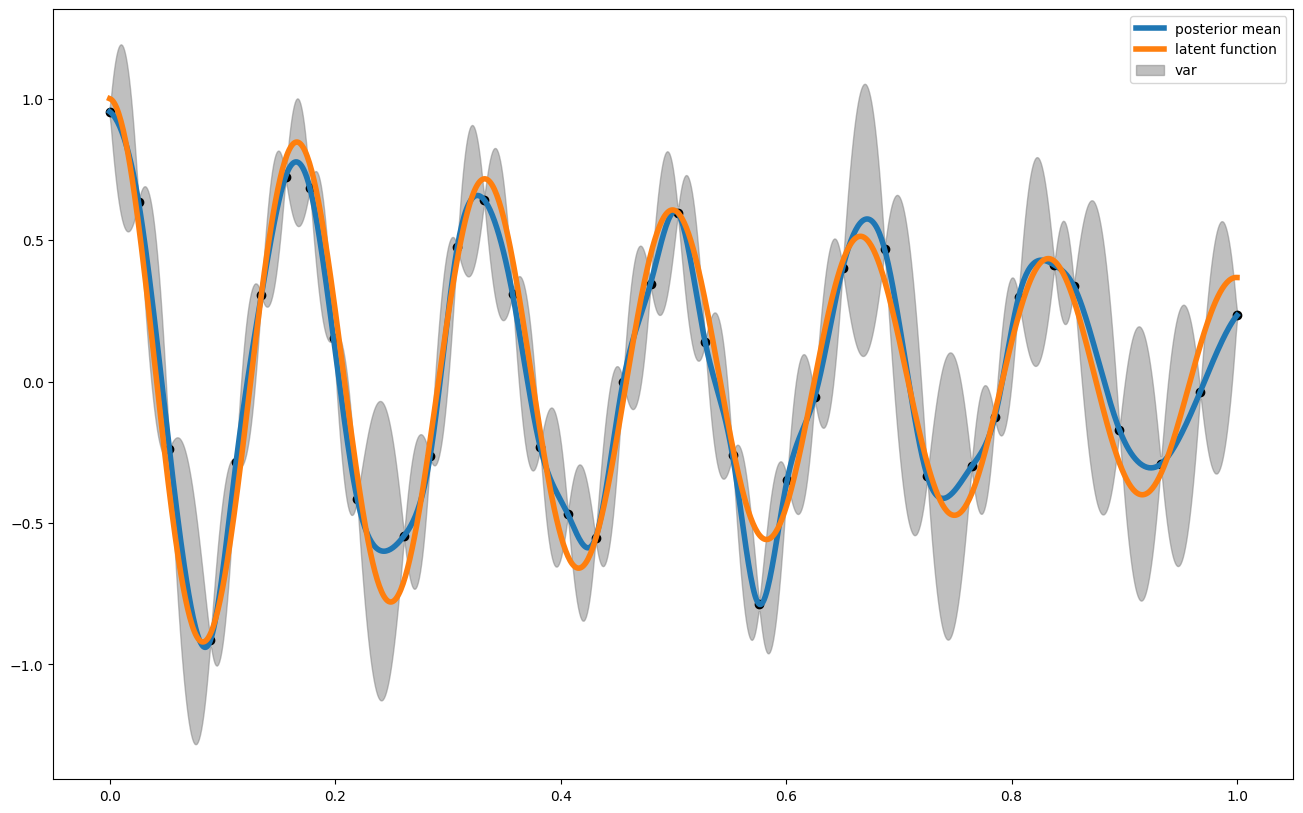

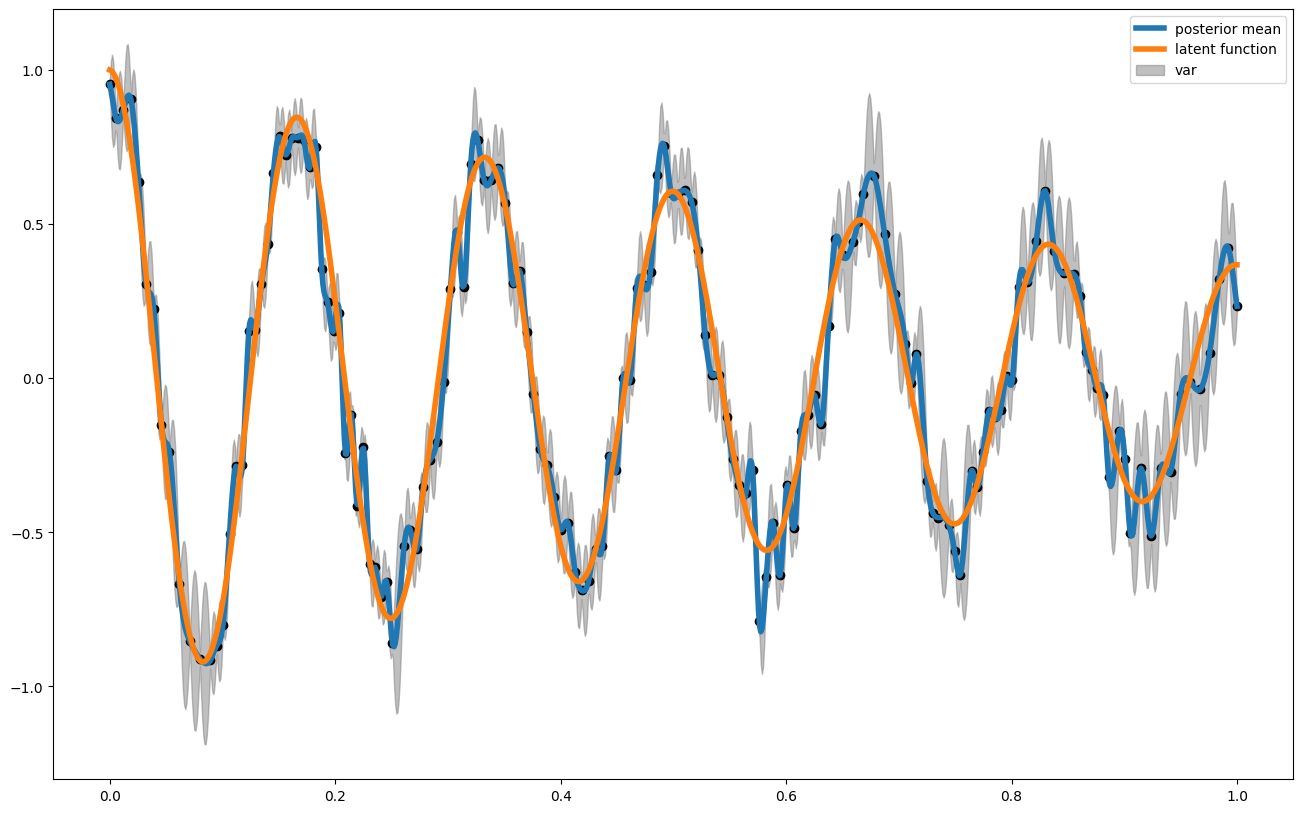

In [5]:
my_gp = GPOptimizer(x_data,y_data,)
my_gp.train()

train_at = [10,20,30, 150] #optional
for i in range(200):
    new = my_gp.ask(np.array([[0.,1.]]))["x"]
    my_gp.tell(new, f1(new).reshape(len(new)))
    if i in train_at: 
        my_gp.train()
        x_pred = np.linspace(0,1,1000)

        mean1 = my_gp.posterior_mean(x_pred.reshape(-1,1))["m(x)"]
        var1 =  my_gp.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]
        plt.figure(figsize = (16,10))
        plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
        plt.plot(x_pred1D,f1_without_noise(x_pred1D), label = "latent function", linewidth = 4)
        plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
        plt.scatter(my_gp.x_data,my_gp.y_data, color = 'black')
        plt.legend()
        plt.show()



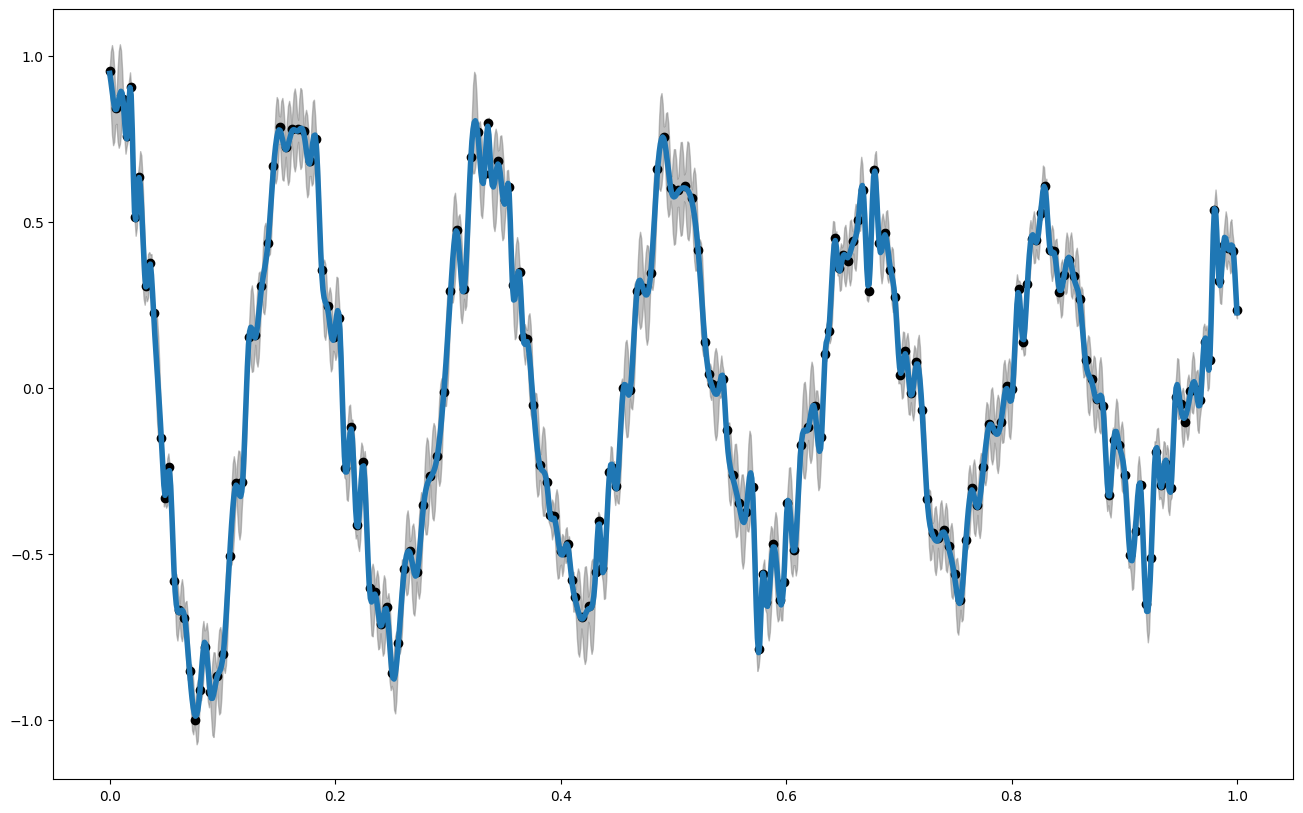

In [6]:
#let's make a prediction
x_pred = np.linspace(0,1,1000)

mean1 = my_gp.posterior_mean(x_pred.reshape(-1,1))["m(x)"]
var1 =  my_gp.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]
plt.figure(figsize = (16,10))
plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
# plt.plot(x_pred1D,f1(x_pred1D), label = "latent function", linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
plt.scatter(my_gp.x_data,my_gp.y_data, color = 'black')


# ##looking at some validation metrics
# print(my_gp.rmse(x_pred1D,f1(x_pred1D)))
# print(my_gp.crps(x_pred1D,f1(x_pred1D)))

# Different Kernel

In [7]:
# Stationary kernel: decaying periodic
from gpcam.kernels import *




def skernel(x1, x2, hps):
    """
    Stationary kernel: decaying periodic
    
    hps[0]: amplitude (scalar factor)
    hps[1]: length scale of periodic kernel
    hps[2]: period of periodic kernel
    hps[3]: length scale of SE kernel
    """
    d = get_distance_matrix(x1, x2)
    k_periodic = periodic_kernel(d, hps[1], hps[2])
    k_decay = squared_exponential_kernel(d, hps[3])
    return hps[0] * k_periodic * k_decay

hps_init = np.array([1.0, 0.2, 1/6, 0.5])  # smoother decay

bounds = np.array([
    [1e-4, 10.0],     # amplitude
    [1e-2, 1.0],      # periodic length scale — min 0.01
    [0.1, 1.0],       # period — assume you know it roughly
    [1e-2, 10.0],     # RBF length scale — min 0.01
])

In [8]:
my_gp_custom_kernel = GPOptimizer(x_data,y_data, init_hyperparameters=hps_init,  kernel_function= skernel, noise_variances = np.ones(x_data.shape[0]) * var**2)
my_gp_custom_kernel.train(hyperparameter_bounds=bounds)


array([2.30288784, 0.79274672, 0.87543454, 0.68731797])

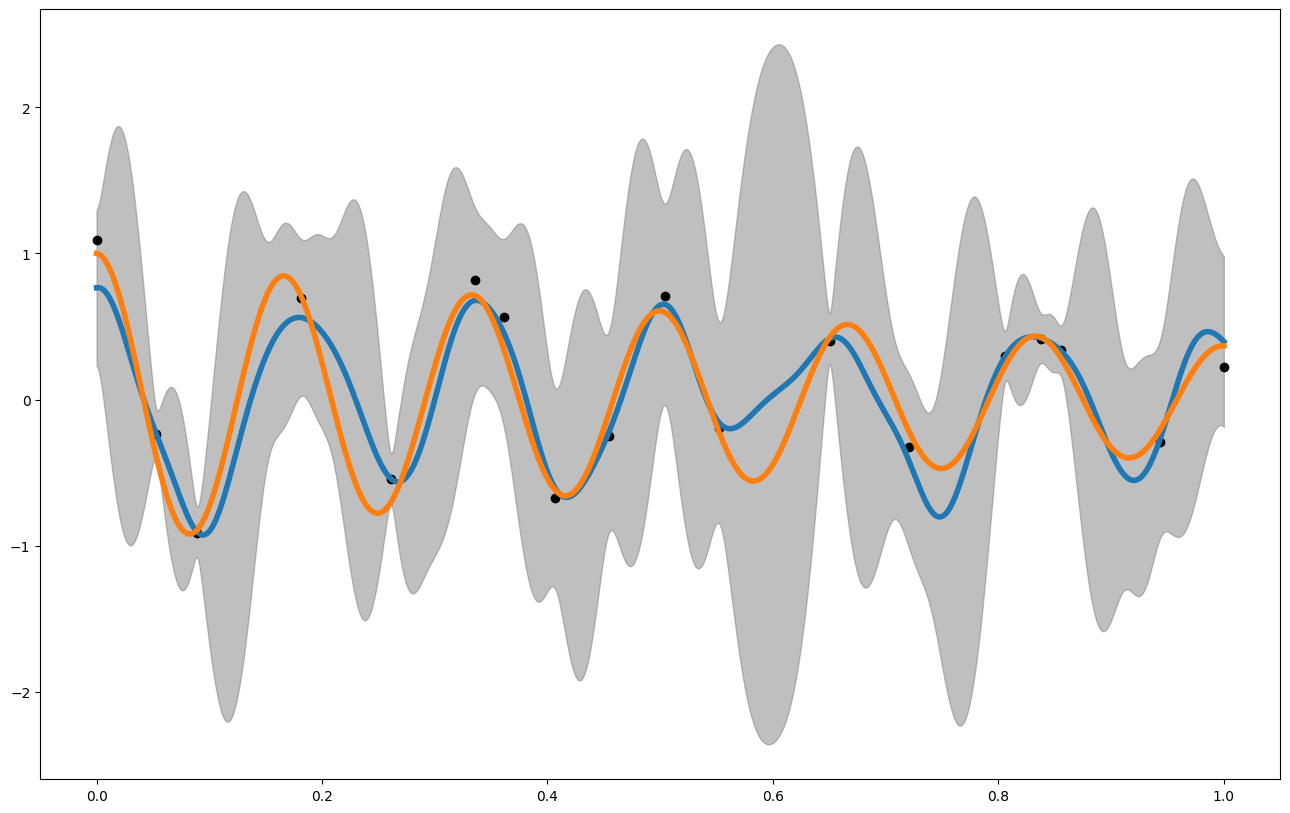

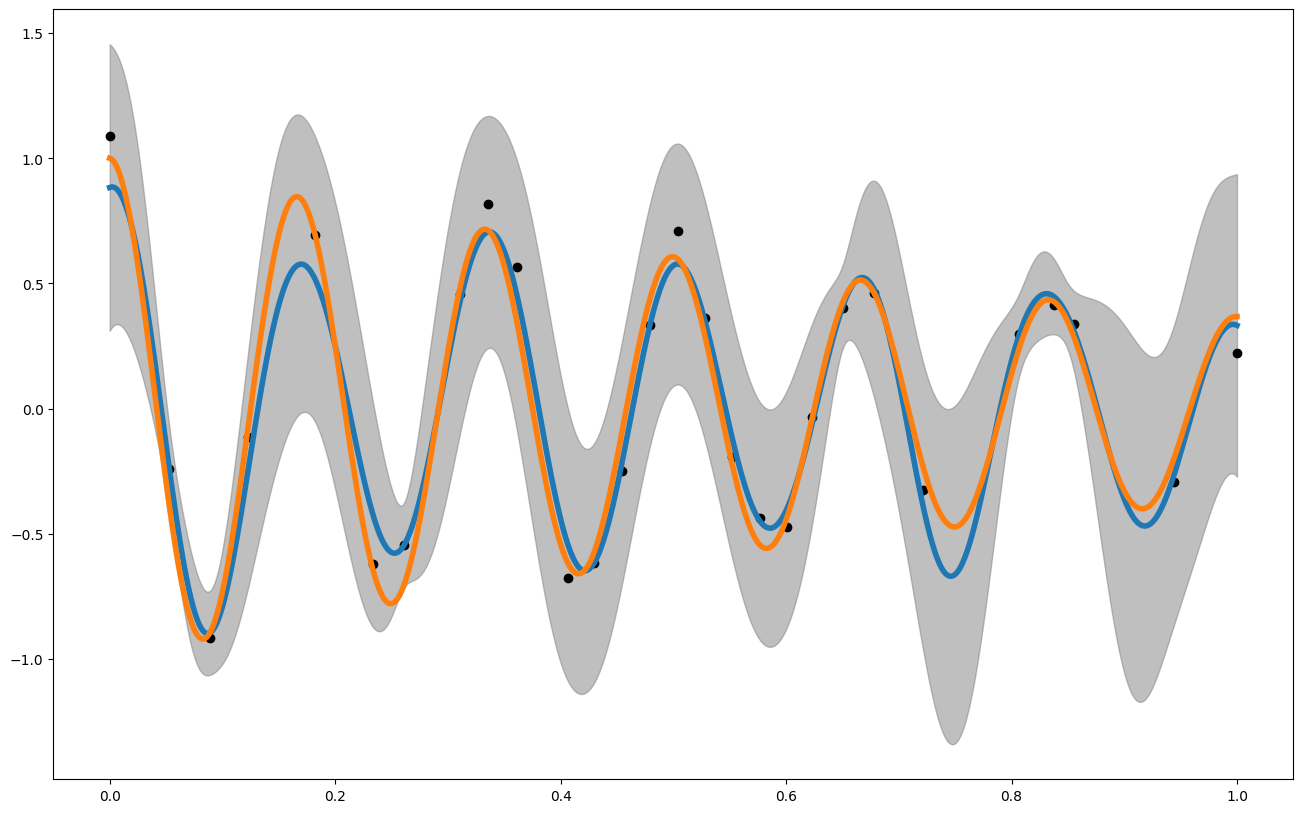

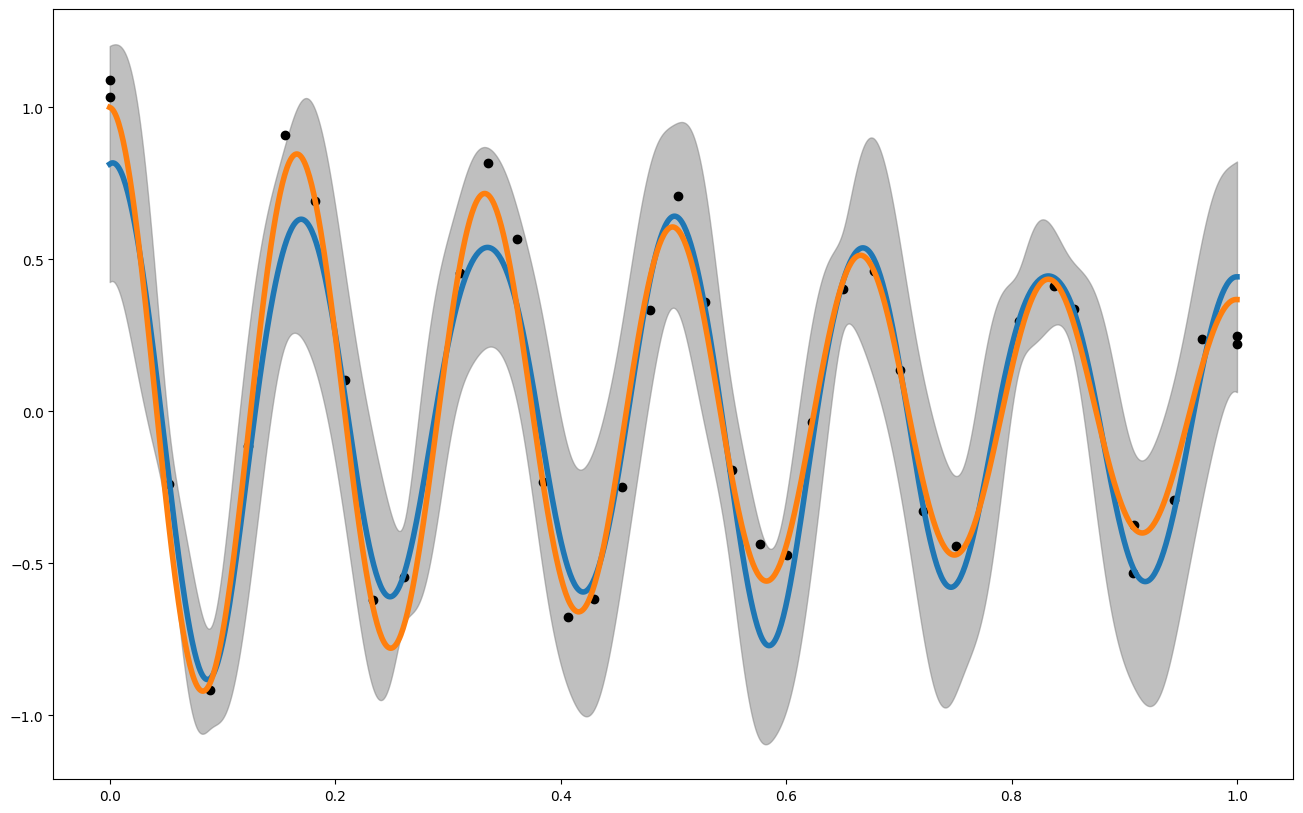

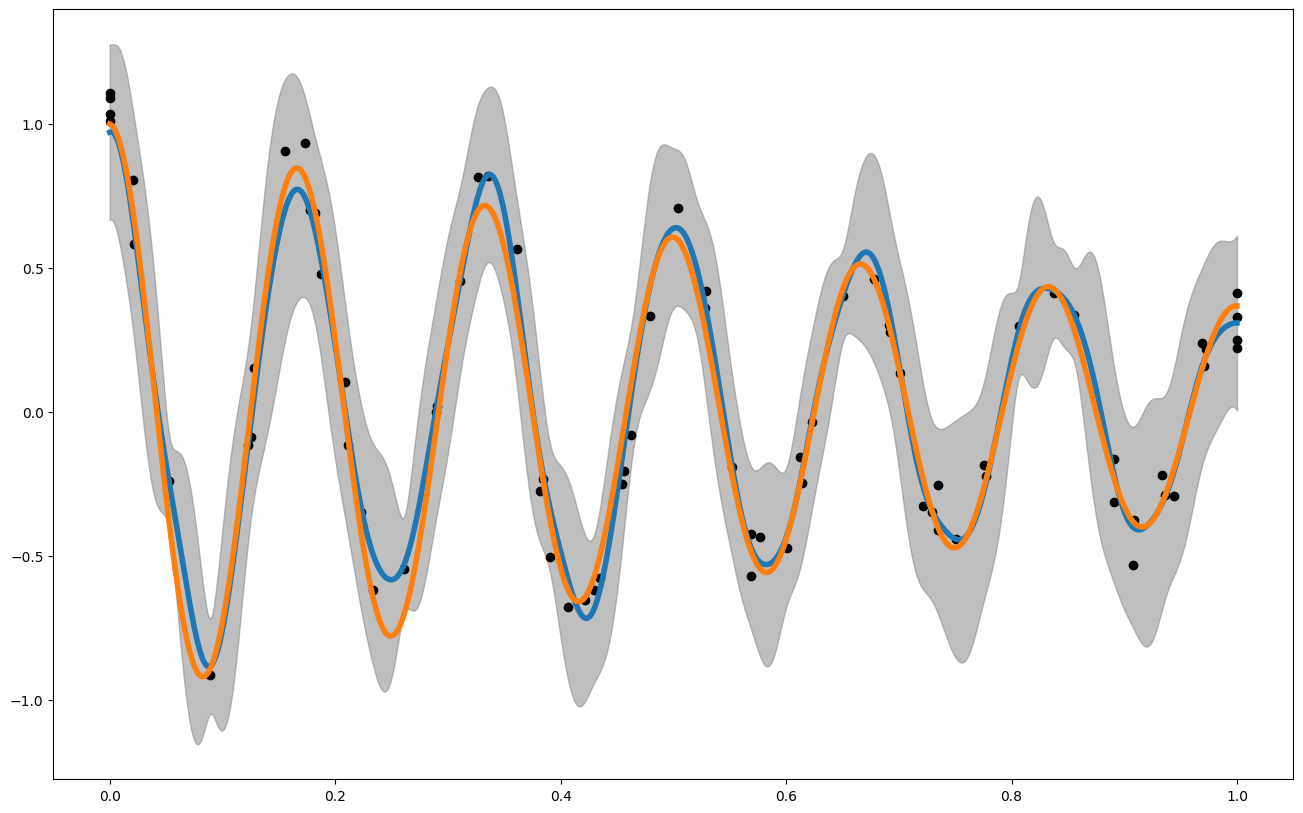

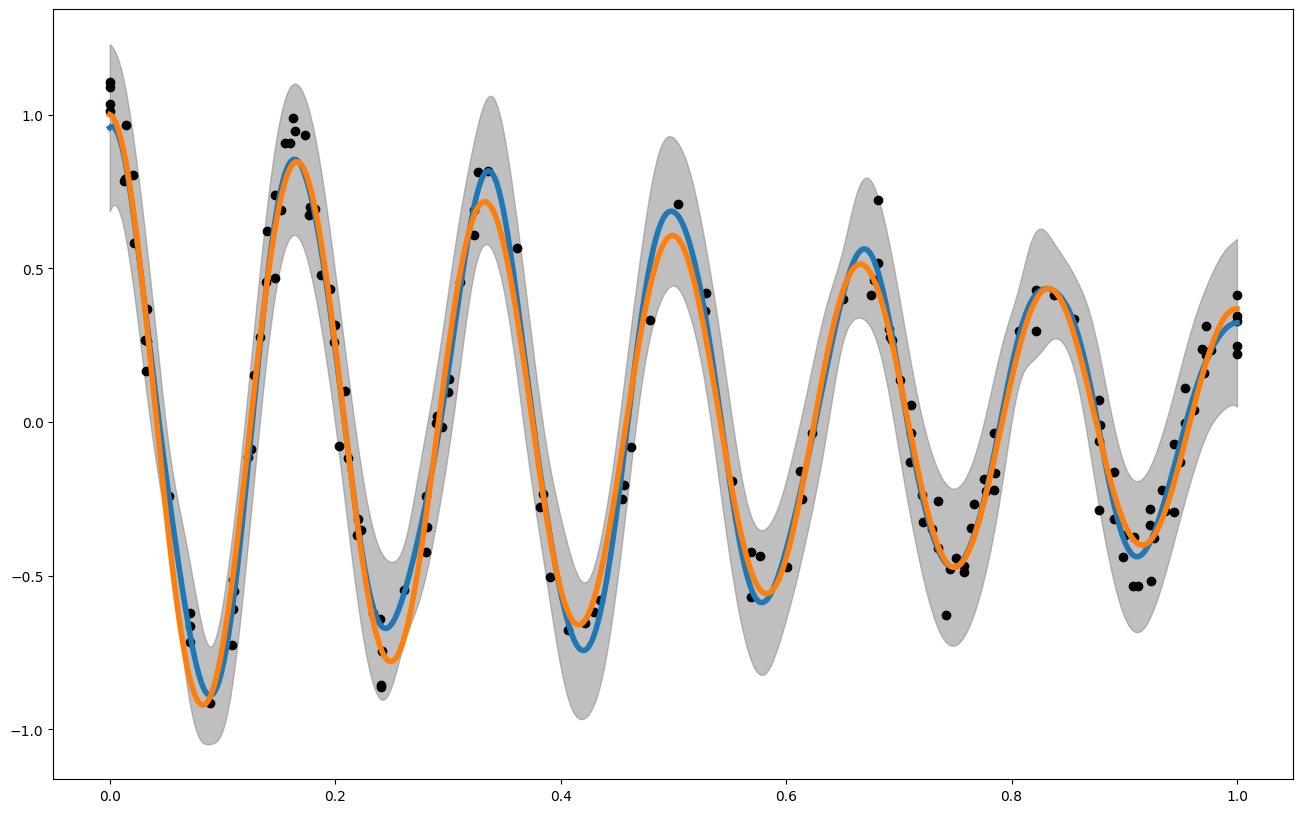

In [9]:


train_at = [10,20,30, 70, 150] #optional
for i in range(200):
    new = my_gp_custom_kernel.ask(np.array([[0.,1.]]))["x"]
    my_gp_custom_kernel.tell(new, f1(new).reshape(len(new)),  noise_variances=np.array([var]))
    if i in train_at: 
        my_gp_custom_kernel.train(hyperparameter_bounds=bounds)
        x_pred = np.linspace(0,1,1000)

        mean1 = my_gp_custom_kernel.posterior_mean(x_pred.reshape(-1,1))["m(x)"]
        var1 =  my_gp_custom_kernel.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]
        plt.figure(figsize = (16,10))
        plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
        plt.plot(x_pred1D,f1_without_noise(x_pred1D), label = "latent function", linewidth = 4)
        plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
        plt.scatter(my_gp_custom_kernel.x_data,my_gp_custom_kernel.y_data, color = 'black')
        plt.show()




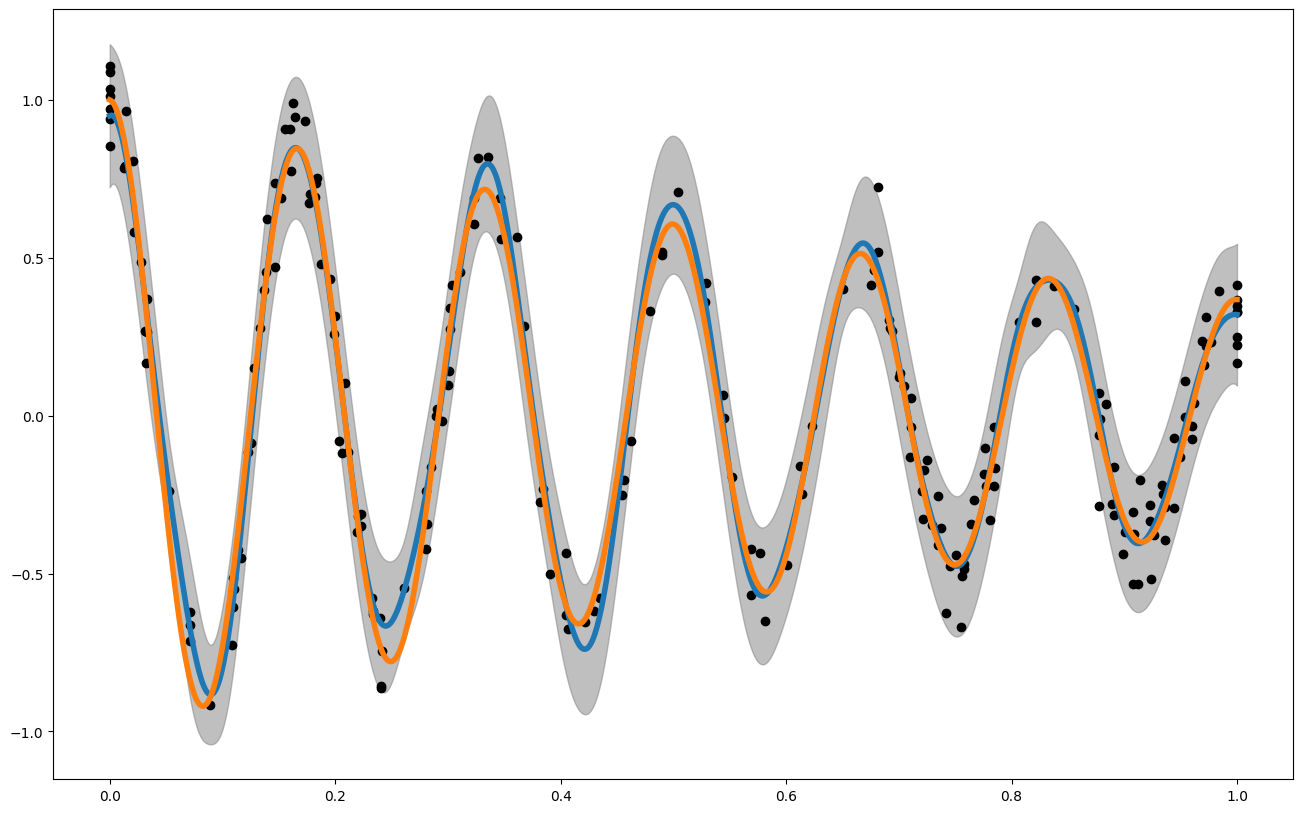

In [10]:
x_pred = np.linspace(0,1,1000)
mean1 = my_gp_custom_kernel.posterior_mean(x_pred.reshape(-1,1))["m(x)"]
var1 =  my_gp_custom_kernel.posterior_covariance(x_pred.reshape(-1,1), variance_only=False, add_noise=True)["v(x)"]
plt.figure(figsize = (16,10))
plt.plot(x_pred,mean1, label = "posterior mean", linewidth = 4)
plt.plot(x_pred1D,f1_without_noise(x_pred1D), label = "latent function", linewidth = 4)
plt.fill_between(x_pred, mean1 - 3. * np.sqrt(var1), mean1 + 3. * np.sqrt(var1), alpha = 0.5, color = "grey", label = "var")
plt.scatter(my_gp_custom_kernel.x_data,my_gp_custom_kernel.y_data, color = 'black')
plt.show()